# Framingham Heart Disease Risk Study
 ## Exploratory Data Analysis

## 1. Sourcing and loading

### 1.1 Import libraries

In [1]:
# Working with data
import numpy as np
import pandas as pd

# Visualization and exploration
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from pca import pca

# Modeling
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# QOL things
# !pip install tqdm
from tqdm.notebook import tqdm # Progress bar
tqdm.set_lock(None)  # Disable thread locking to prevent issues in Jupyter notebooks

# Custom functions
from functions import grid_plots, ecdf, get_function_code, sb_utils

### 1.2 Load data

In [2]:
df_inputed_path = '../data/interim/data_droped.csv'
df_drop_path = '../data/interim/data_imputed.csv'

df = pd.read_csv(df_inputed_path)
df_drop = pd.read_csv(df_drop_path)

### 1.3 Exploring data

In [3]:
df.shape, df_drop.shape

((3656, 16), (4238, 16))

As a disclaimer, the 'data_clean' and 'data_winsorized' are practically the same data sets, but within the winsorized data all the extreme outliers were winsorized to fit within the range of (Q1 - 1.5*IQR) and (Q3 + 1.5*IQR). So it will make sense to focus on just 'df_clean' data set for now, and keep the 'df_winsorized' for the future model evaluations.

In [4]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4,0,0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2,0,0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,1,20,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3,1,30,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3,1,23,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3656 non-null   int64  
 1   age              3656 non-null   int64  
 2   education        3656 non-null   int64  
 3   currentSmoker    3656 non-null   int64  
 4   cigsPerDay       3656 non-null   int64  
 5   BPMeds           3656 non-null   int64  
 6   prevalentStroke  3656 non-null   int64  
 7   prevalentHyp     3656 non-null   int64  
 8   diabetes         3656 non-null   int64  
 9   totChol          3656 non-null   float64
 10  sysBP            3656 non-null   float64
 11  diaBP            3656 non-null   float64
 12  BMI              3656 non-null   float64
 13  heartRate        3656 non-null   float64
 14  glucose          3656 non-null   float64
 15  TenYearCHD       3656 non-null   int64  
dtypes: float64(6), int64(10)
memory usage: 457.1 KB


#### Column definitions:
* male: (nominal)
    * 0 for female
    * 1 for male
* age: (continuous)
    * Age of the patient 
* education: (ordinal) (presumably)
    1. Some high school
    2. High school diploma
    3. Some college or vocational training
    4. College degree or higher
* current_smoker: (nominal)
    * 1 - Yes
    * 0 - No 
* cigsPerDay: (continuous)
    * Number of cigarettes smoked each day
* BPMeds: (nominal)
    * 1 if patient takes anti-hypertension medications
    * 0 if patient does not take anti-hypertension medications
* prevalentStroke: (nominal)
    * 1 if patient previously had stroke
    * 0 if patient did not have stroke in the past
* prevalentHyp: (nominal)
    * 1 if patient previously had diagnosed hypertension
    * 0 if patient did not have hypertension in the past
* diabetes: (nominal)
    * 1 if patient has diabetes
    * 0 if patient does not have diabetes
* totChol: (continuous)
    * Total cholesterol concentration (mg/dl)
* sysBP: (continuous)
    * Systolic blood pressure (mmHg)
* diaBP: (continuous)
    * Diastolic blood pressure (mmHg)
* BMI: (continuous)
    * Body Mass Index
* heartRate: (continuous)
    * Heart Rate (bpm)
* glucose: (continuous)
    * Blood glucose concentration (mg/dl)
* TenYearCHD: (nominal) ----> Target
    * 1 if patient has 10 year risk of coronary heart disease (CHD)
    * 0 if patient has no 10 year CHD risk

Let's explore the target value 'TenYearCHD' 

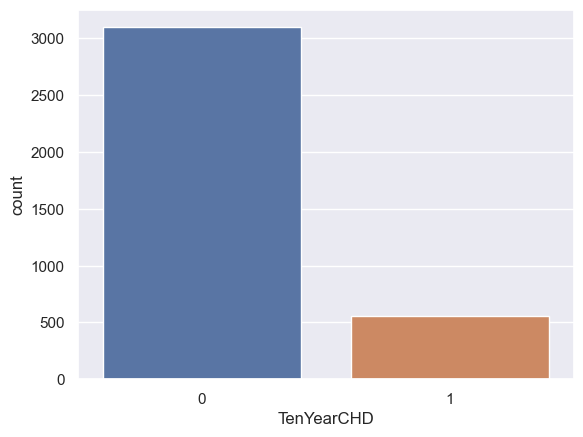

In [6]:
sns.countplot(data=df, x='TenYearCHD');

In [7]:
df[df['TenYearCHD'] == 0]['TenYearCHD'].count() / df[df['TenYearCHD'] == 1]['TenYearCHD'].count()
# ['TenYearCHD'].sum() / df.shape[0]

5.563734290843806

There is an imbalance within our target value with ratio of 5.6 / 1 (No Risk / Risk). We will balance this in future and compare model performance.

In [8]:
# Define categorical and continuous columns
categorical_cols = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
cont_units = ['years', 'cigs/day', 'mg/dl', 'mmHg', 'mmHg', 'kg/m^2', 'bpm', 'mg/dl']


Let's visualize our columns. Starting with categorical values.

In [9]:
df[categorical_cols].describe()

,male,education,currentSmoker,BPMeds,prevalentStroke,prevalentHyp,diabetes
count,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000
mean,0.443654,1.979759,0.489059,0.030361,0.005744,0.311543,0.027079
std,0.496883,1.022657,0.499949,0.171602,0.075581,0.463187,0.162335
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


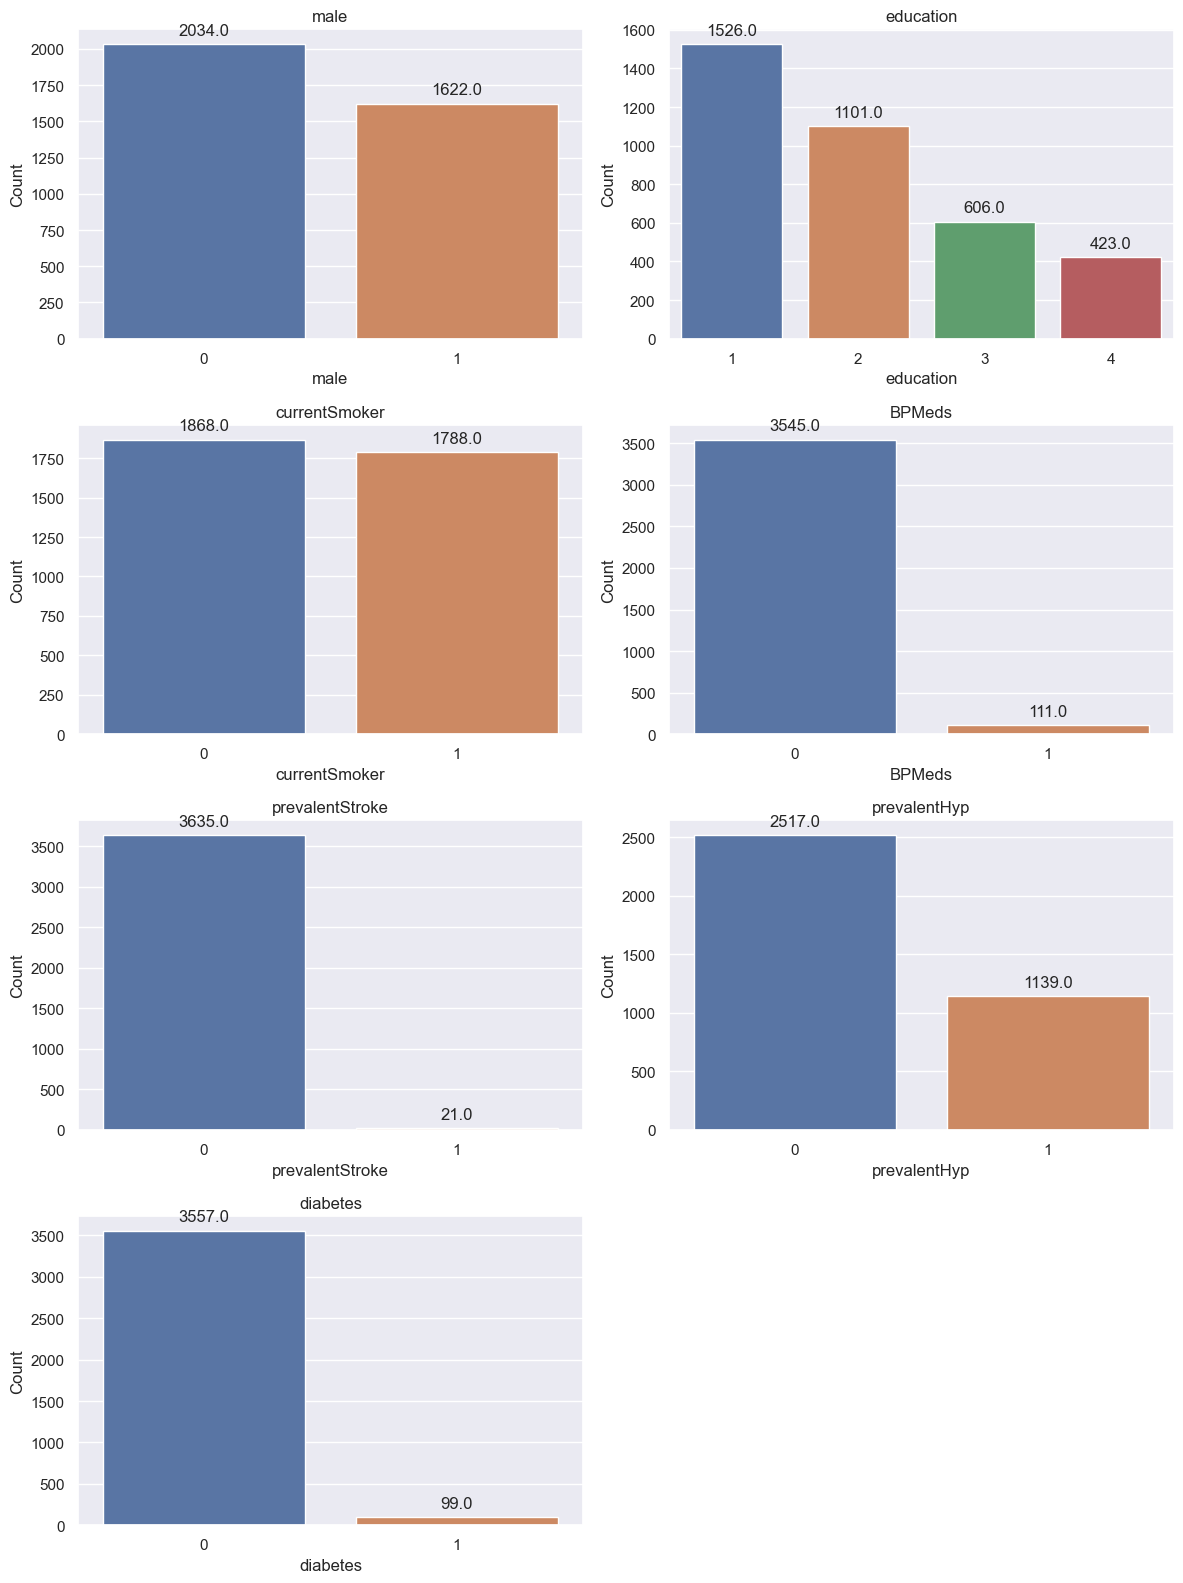

In [10]:
grid_plots.plot_grid_bar(df, categorical_cols)

We can see that out of all categorical columns the most balanced are 'sex' and 'is_smoking'. 
Education column shows the expected distribution of education levels.
Prevalent hypertension column shows that approximately 1/3 of all patients have diagnosis of hypertension, but only 94! out of them take any blood pressure medications. Compared to the column 'hypertension_calc' that was calculated in previous step, there is not much difference in the diagnosed hypertension distribution.
We will do the same with the diabetes column, comparing it with the blood sugar levels, because there are only 81 patients with established diagnosis of diabetes.
Prevalent stroke column (with only 19 positive patients) cannot be compared with any other column. Although we can look if it's more prevalent in elderly patients, and if this column is of any use.

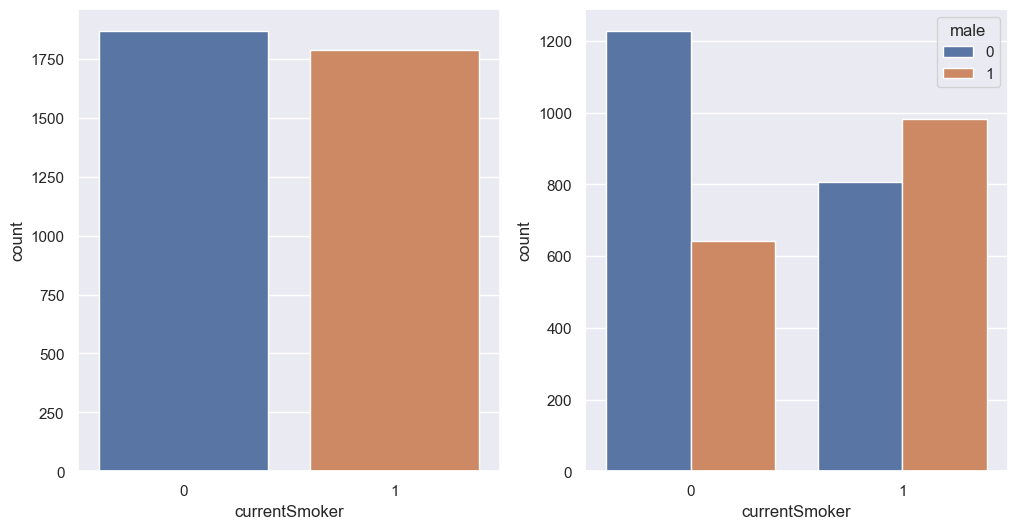

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Plot of smokers
sns.countplot(data=df, x='currentSmoker', ax=ax[0])

# Plot of smokers by age
sns.countplot(data=df, x='currentSmoker', hue='male', ax=ax[1]);


There are more men among smokers. Out of curiosity let's see how education related with smoking status in the 1970s.

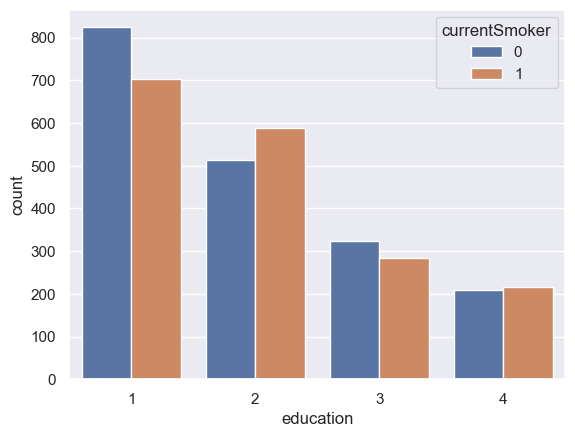

In [12]:
sns.countplot(data=df, x='education', hue='currentSmoker');

That's interesting! The largest portion of non-smokers is within an education level 1 group. Level 2 shows the opposite, with smokers being more prevalent. Level 3 shows similar ratio as level 1. And there are slightly more smokers than non-smokers in the level 4 group. Could this be related to some other factors?

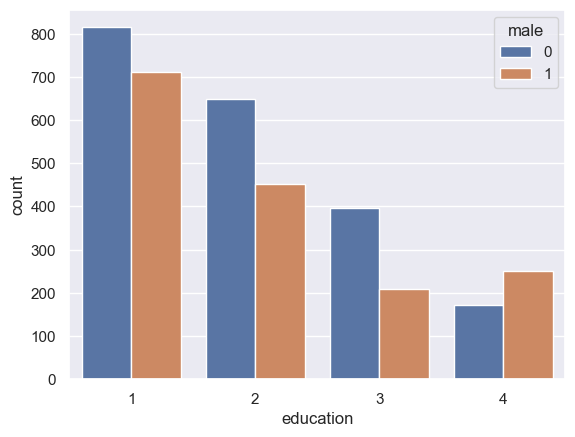

In [13]:
sns.countplot(data=df, x='education', hue='male');

It seems like women are more prevalent in level 1-3 education groups, with 2/1 ratio within the level 3 group. 
Comparing absolute values within the groups makes an impression that almost all smokers within level 1 are men (~800), but can we say that there is an influence within other groups, let's check.

In [14]:
for e in sorted(list(df['education'].unique())):
    print(f'\nEducation {e:.0f}:')
    for male, smok in zip(df['male'].unique(),df['male'].unique()):
        print(f'\tSmoking {smok}: {df.loc[df["education"] == e].loc[df["currentSmoker"] == smok].shape[0]}')
        print(f'\tIs male {male}: {df.loc[df["education"] == e].loc[df["male"] == male].shape[0]}')



Education 1:
	Smoking 1: 702
	Is male 1: 711
	Smoking 0: 824
	Is male 0: 815

Education 2:
	Smoking 1: 588
	Is male 1: 451
	Smoking 0: 513
	Is male 0: 650

Education 3:
	Smoking 1: 283
	Is male 1: 209
	Smoking 0: 323
	Is male 0: 397

Education 4:
	Smoking 1: 215
	Is male 1: 251
	Smoking 0: 208
	Is male 0: 172


As predicted values within education level 1 are almost identical. 
Overall this shows very interesting tendency.


Let's start to mix in some of the continuous variables.
I want to see if there is any pattern in age-sex distribution.

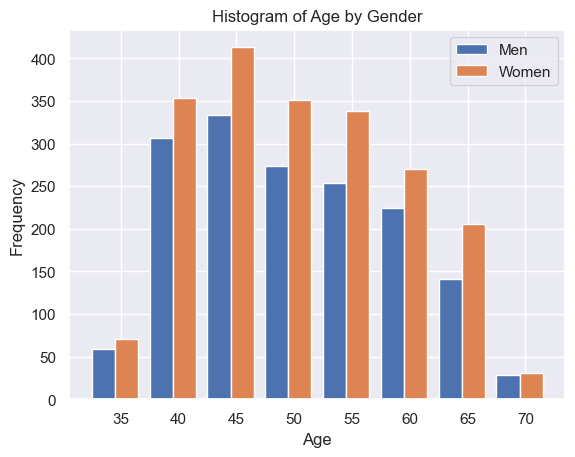

In [15]:
# # Separate data for men and women
men_data = df[df['male'] == 1]['age']
women_data = df[df['male'] == 0]['age']

# Set the bin width
bin_width = 5

# Plot the histogram
plt.hist([men_data, women_data], bins=range(min(df['age']), max(df['age']) + bin_width, bin_width),label=['Men', 'Women'])

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age by Gender')
plt.legend()

# Show the plot
plt.show()

As was shown at the sex count plot, women are just more prevalent in this data in general.

In [16]:
# Describe continuous features
df[continuous_cols].describe()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000
mean,49.557440,9.022155,236.873085,132.368025,82.912062,25.784185,75.730580,81.856127
std,8.561133,11.918869,44.096223,22.092444,11.974825,4.065913,11.982952,23.910128
min,32.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000
25%,42.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000
50%,49.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000
75%,56.000000,20.000000,263.250000,144.000000,90.000000,28.040000,82.000000,87.000000
max,70.000000,70.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000


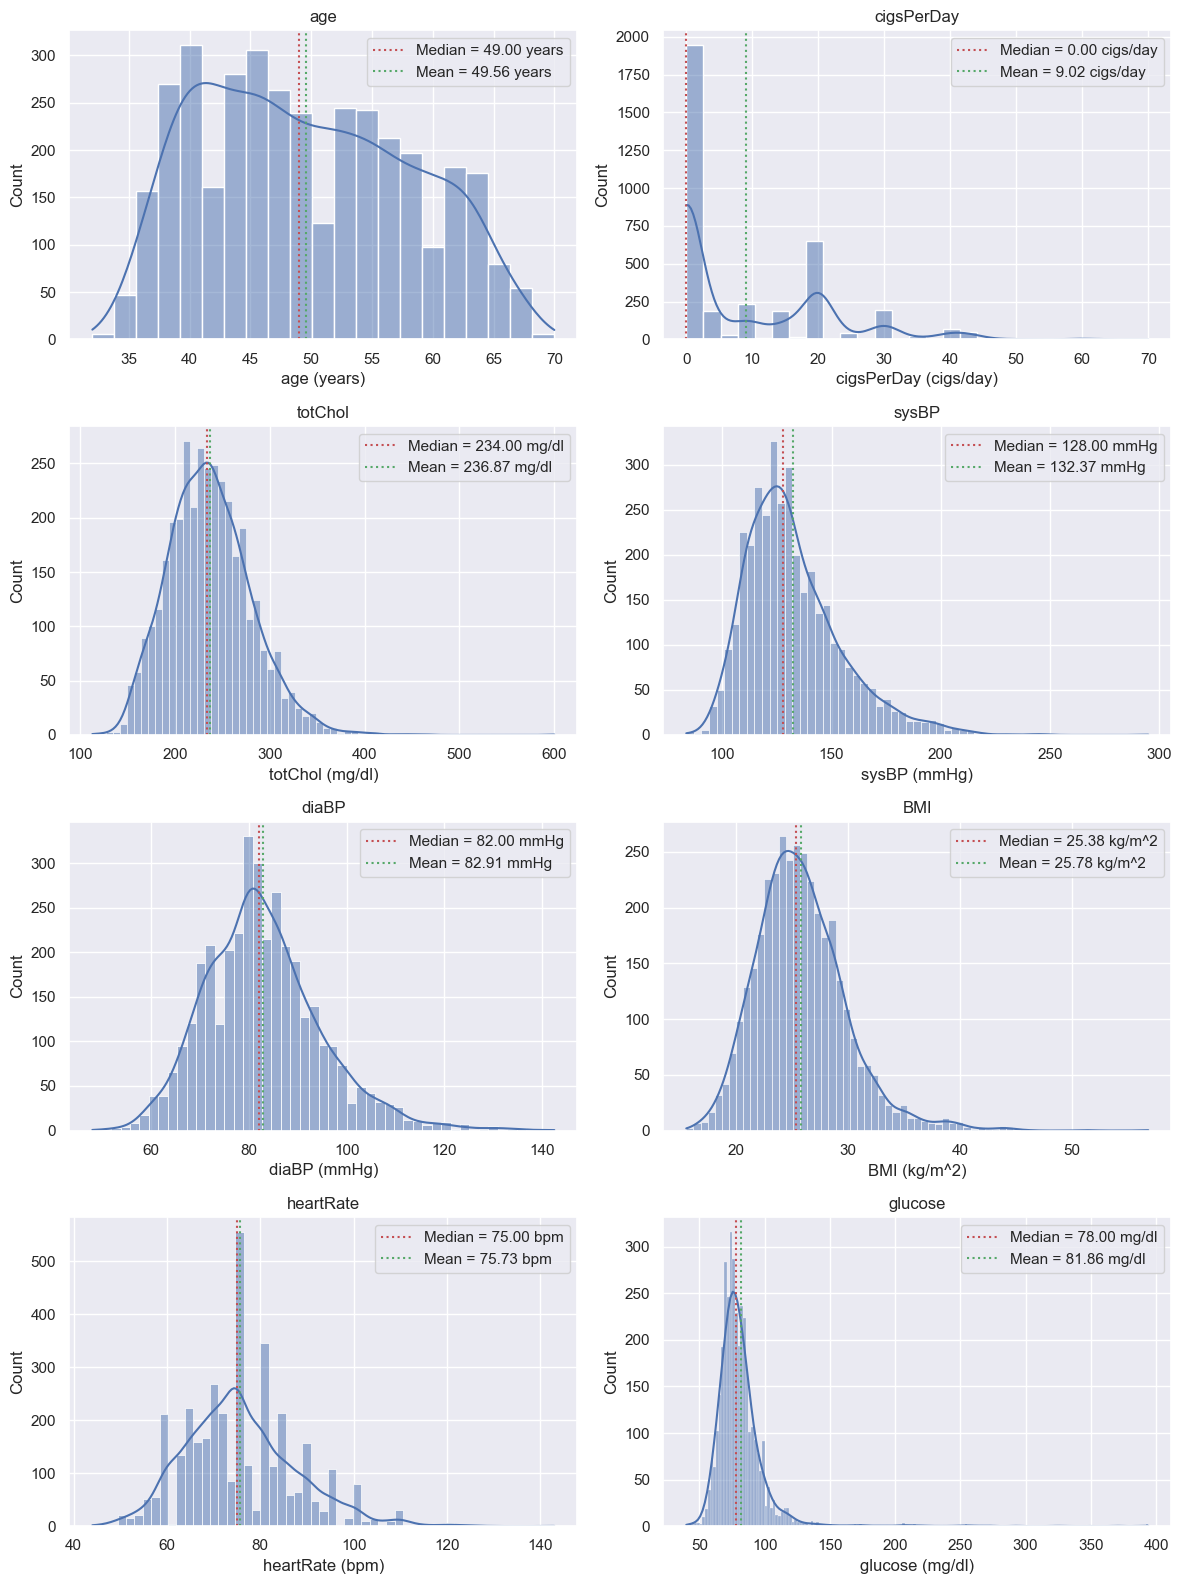

In [17]:
# Plot distributions of continuous variables
grid_plots.plot_grid_displots(data=df, columns=continuous_cols, units_list=cont_units)

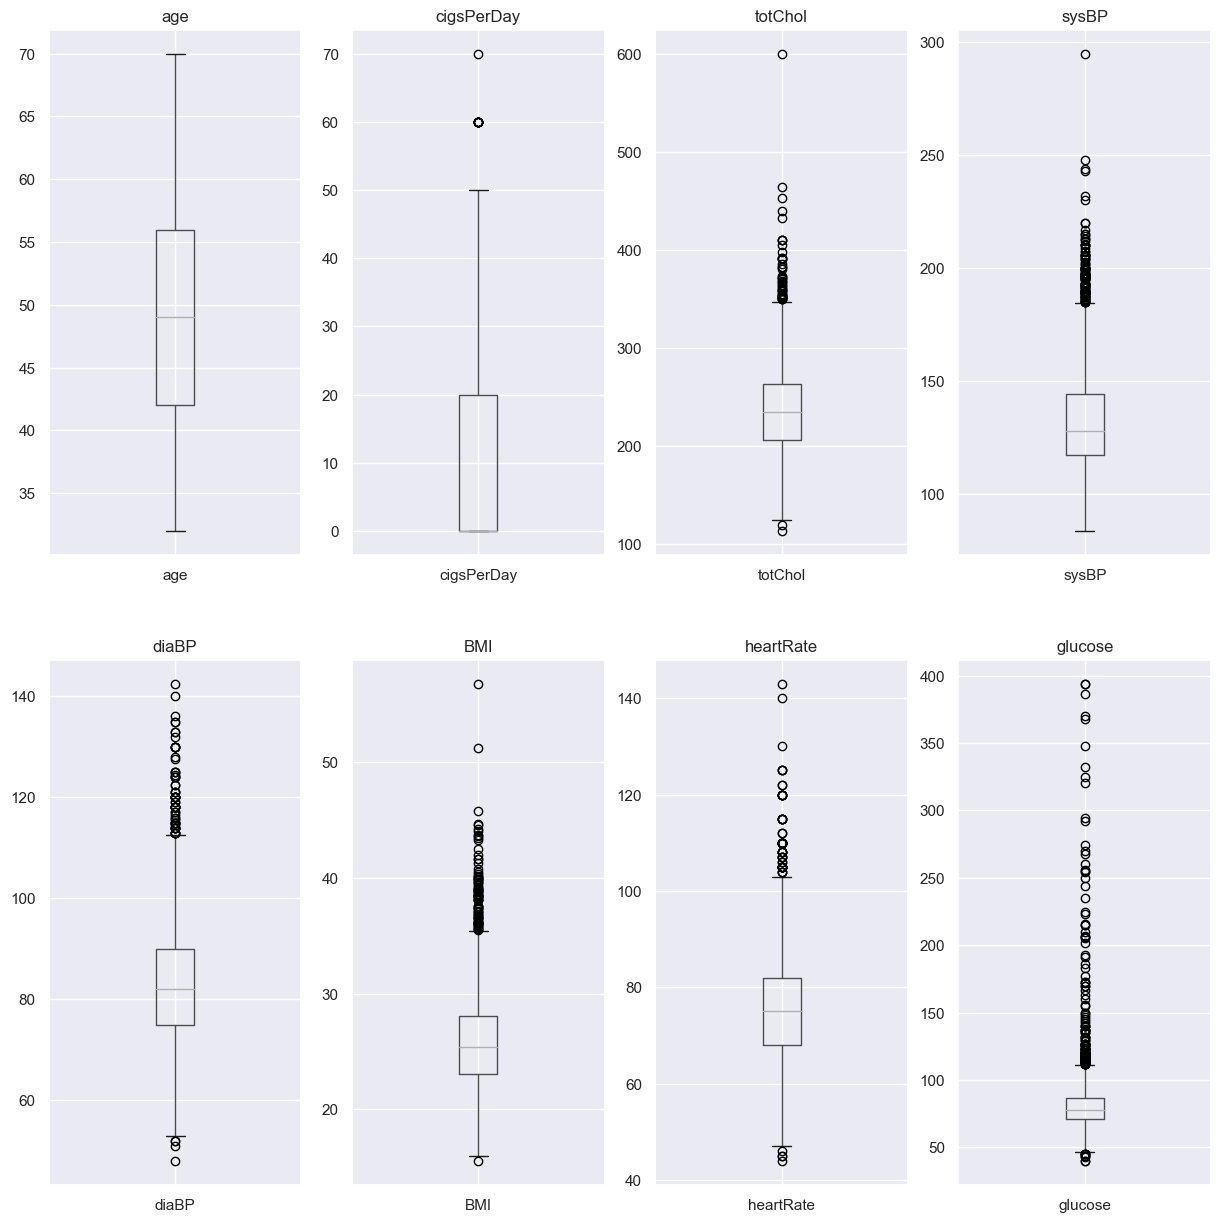

In [18]:
# Plot boxplots for continuous variables
grid_plots.plot_box_grid(data=df, cols=continuous_cols)

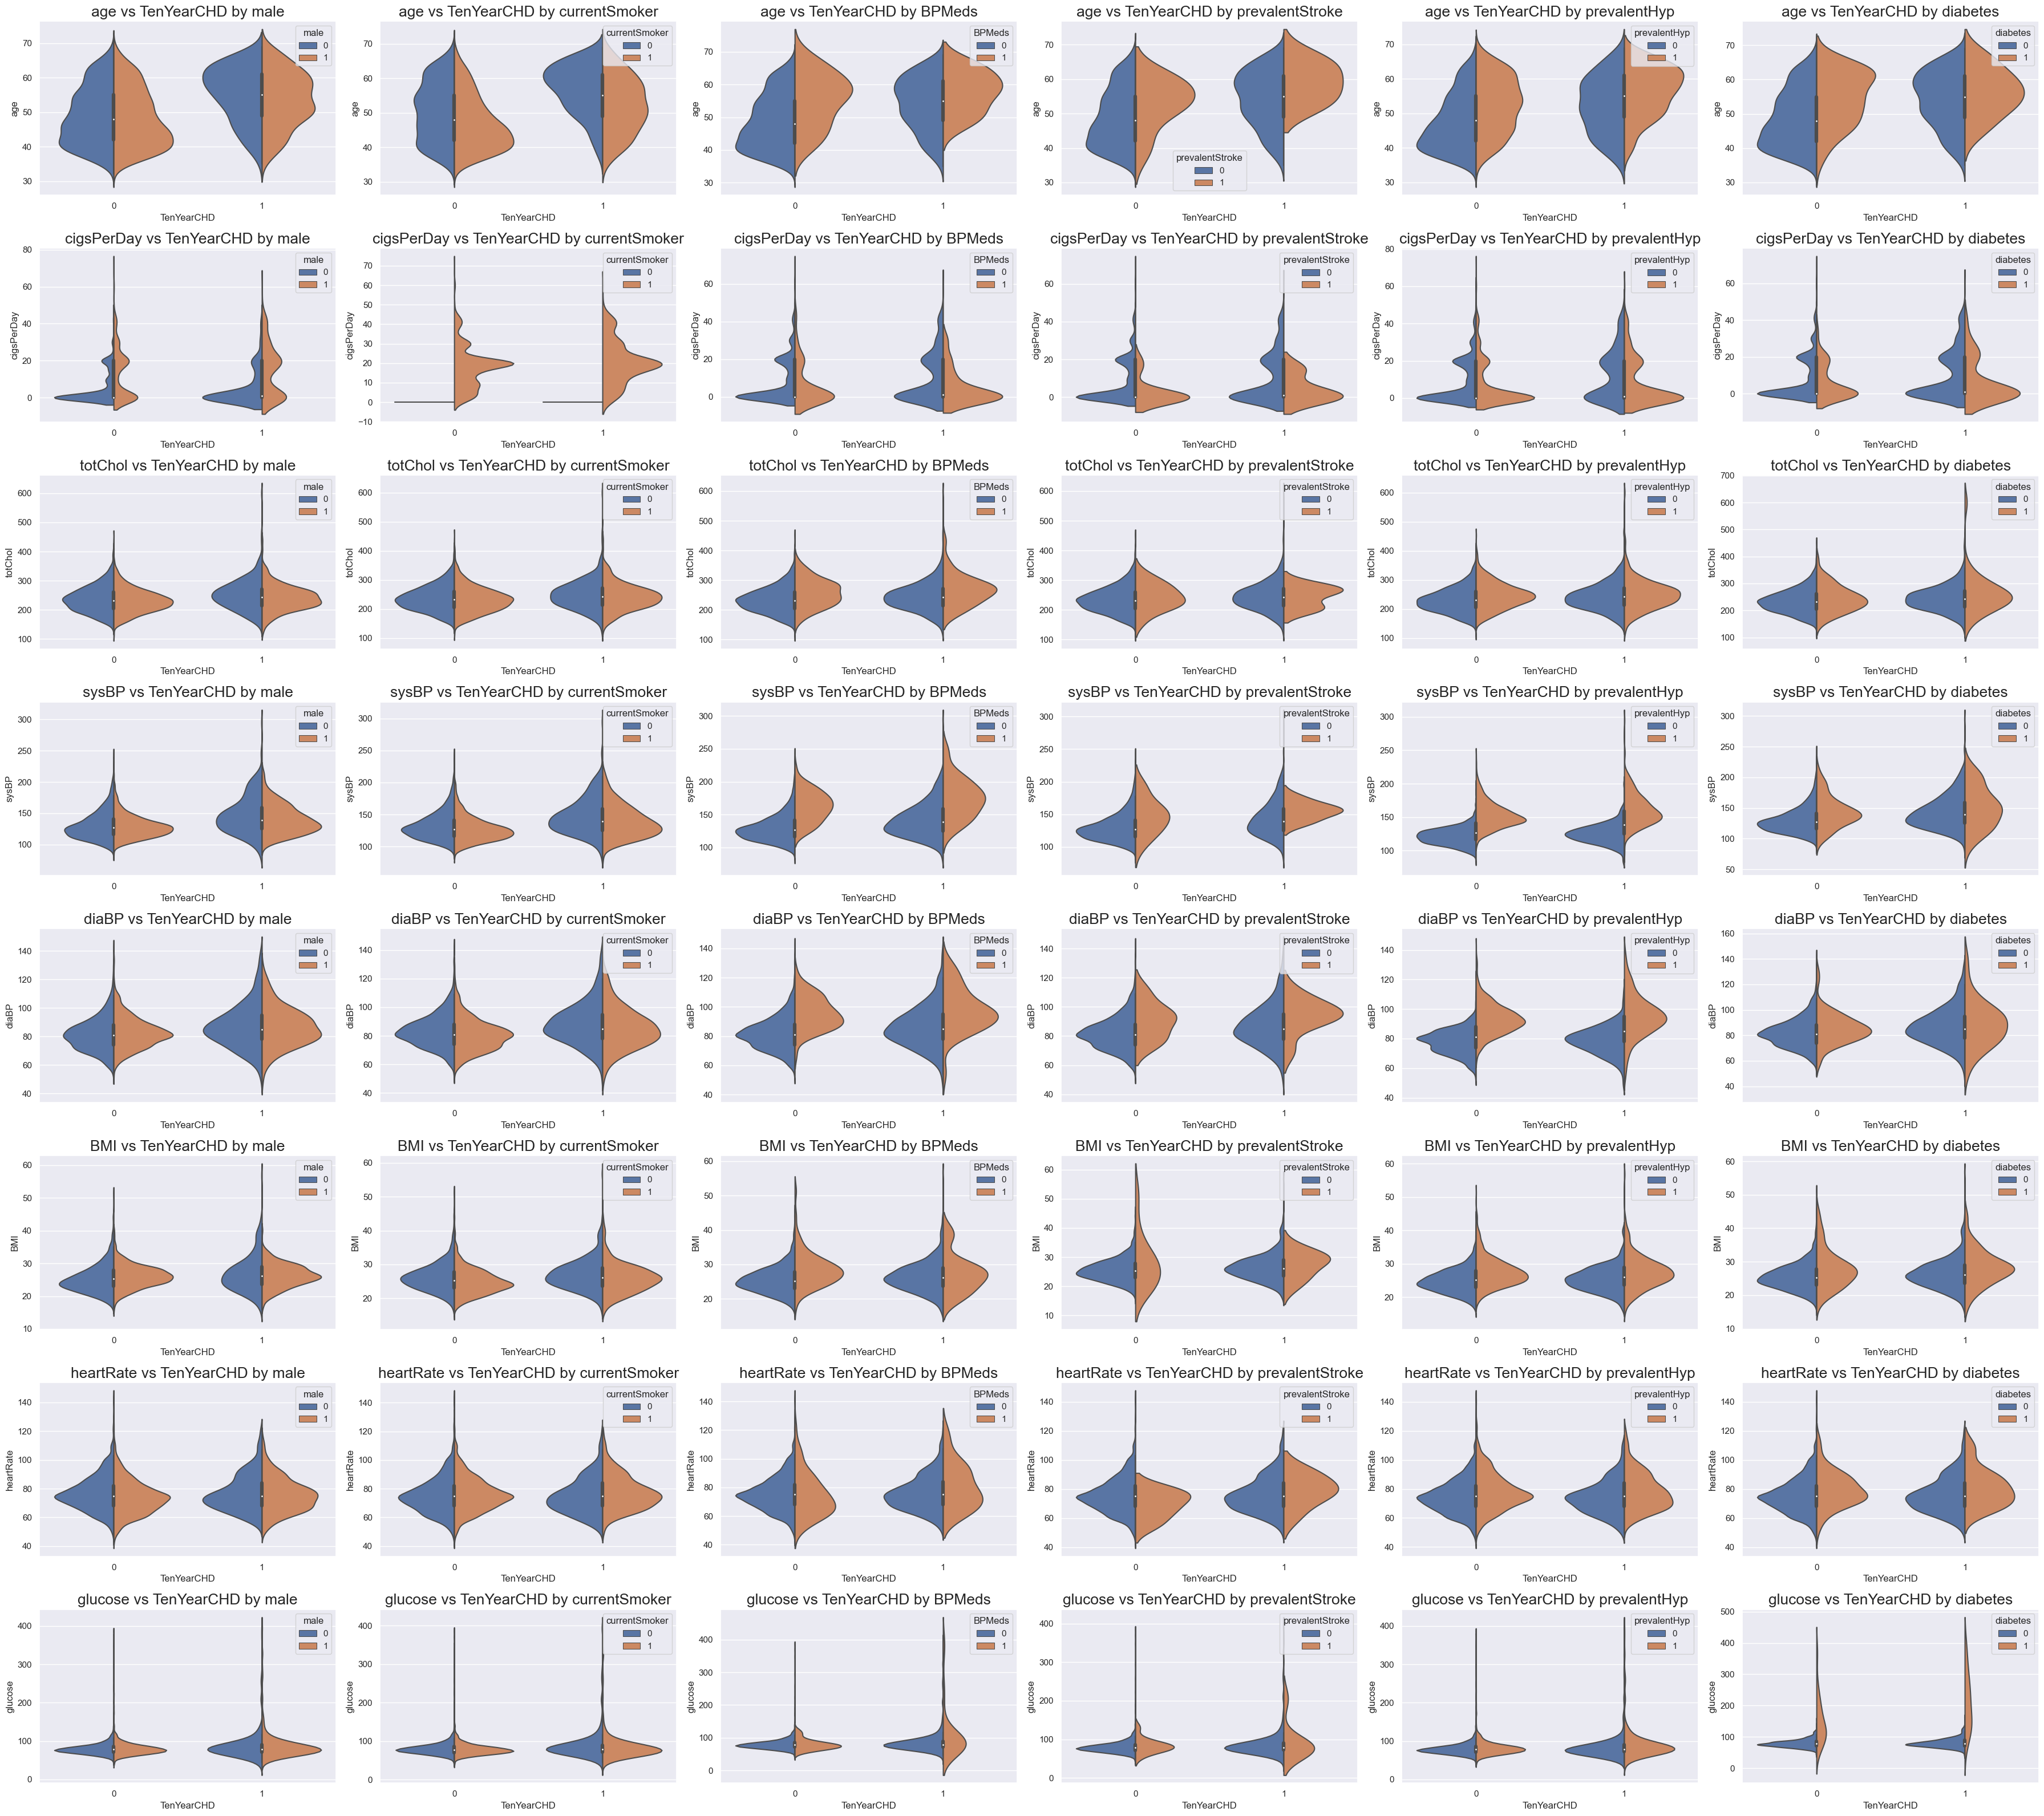

In [19]:
# Plot violin plots of continuous variables paired with bivariate categorical, including TenYearCHD

bivars = categorical_cols.copy()
bivars.remove('education')

grid_plots.plot_grid_violin(data=df, binom='TenYearCHD', continuous_vars=continuous_cols, binom_vars=bivars)

Summary
* Age is one of the strongest factors influencing the 10-year risk of CHD.
* As well as being male.
* Smoking also contributes to 10-year CHD. Number of cigarettes per day may also contribute to the increased risk.
* Blood pressure may also be contributing factor. Although, there is a certain hypo-diagnosis of diabetes in this population. So we might need to categorize glucose values into the stages of hyperglycemia.

Side notes: Many features have interesting but expected behaviors, shifting distributions if they are present:
* Blood pressures tend to be higher in patients that are taking BP medications. Also, patients with higher BP tend to be already taking BP meds.
* Diabetes flattens some distributions (except BMI, which is interesting, because higher BMI values tend to contribute to diabetes in patients)

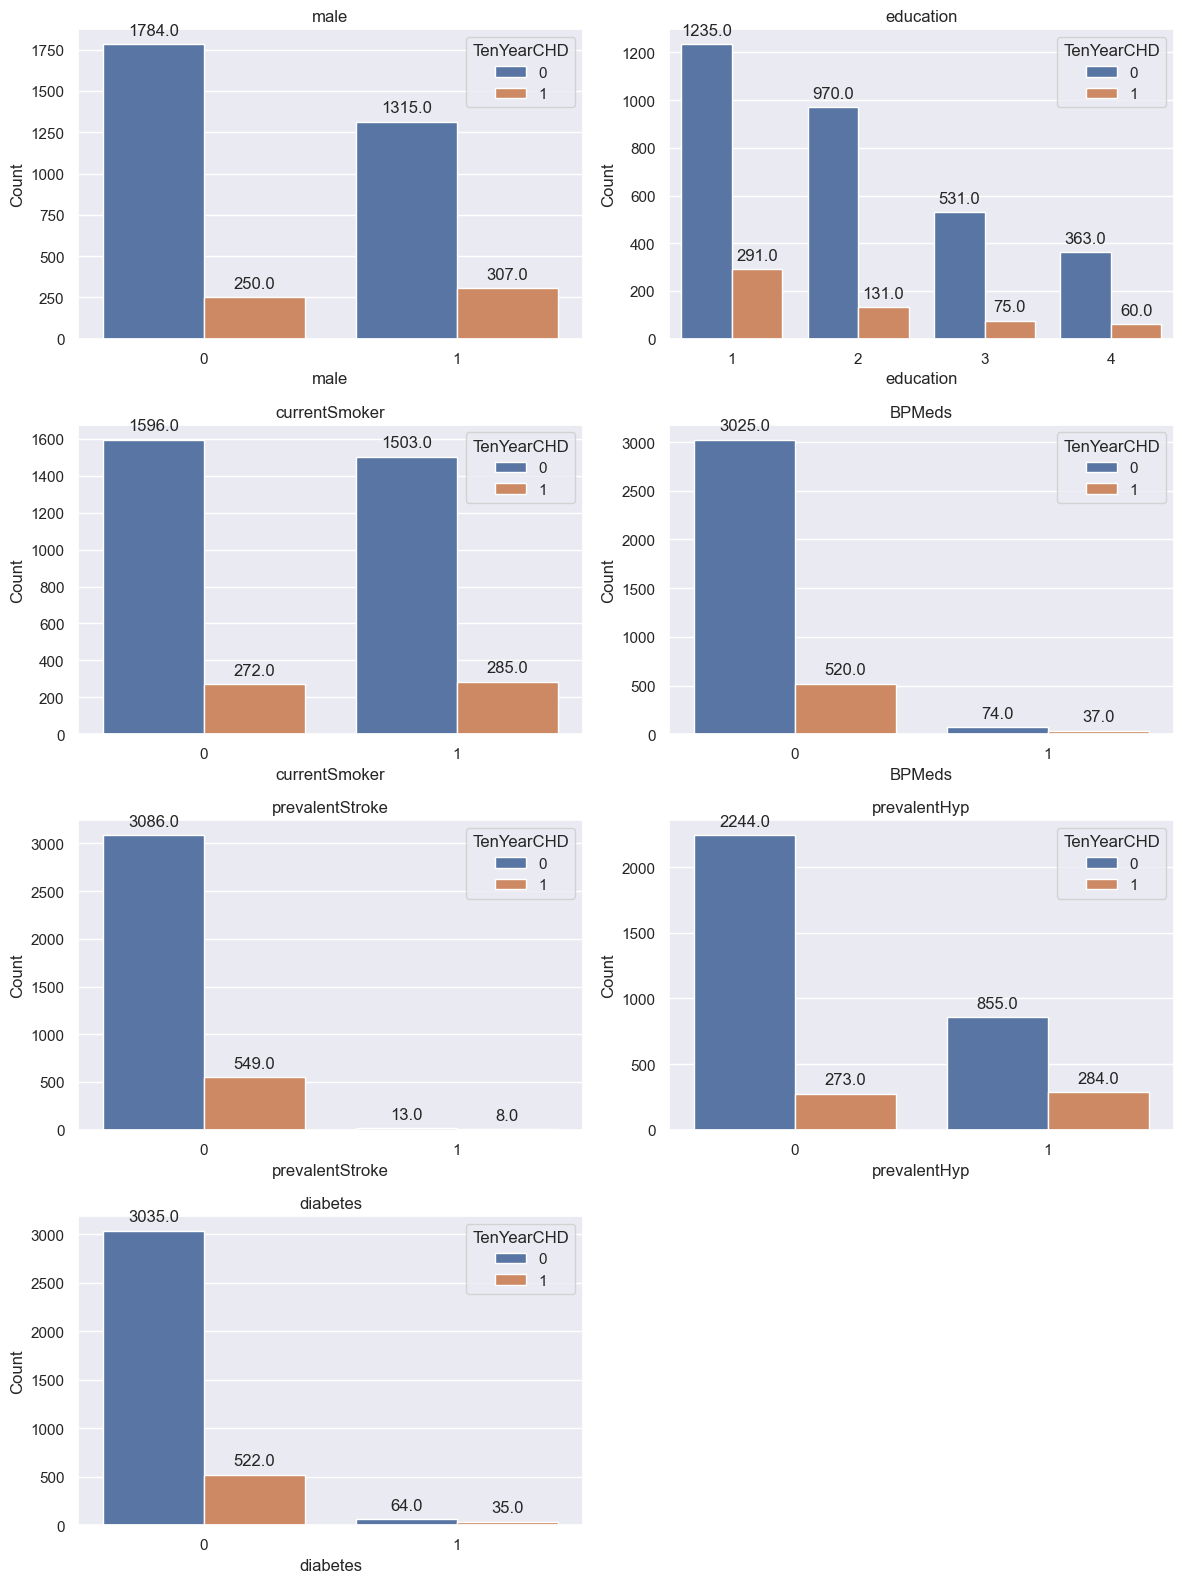

In [20]:
# Call function to draw barplots of the categorical values, groupped by TenYearCHD
grid_plots.plot_grid_bar(data=df, columns=categorical_cols, by='TenYearCHD')

Target value categorical influencers.
1. As was described before, being male seems to increase the risk.
2. Education does not seem to have any influence of target value.
3. Being a smoker increases the risk, but not much really.
4. BP Medications, Prevalent Stroke and Diabetes have not enough positive entries to draw any reasonable conclusion (might need to engineer new features in these categories).
5. Prevalent hypertension, although being quite disbalanced, seems to play a role in increasing the risk (might also engineer a new feature for this category).

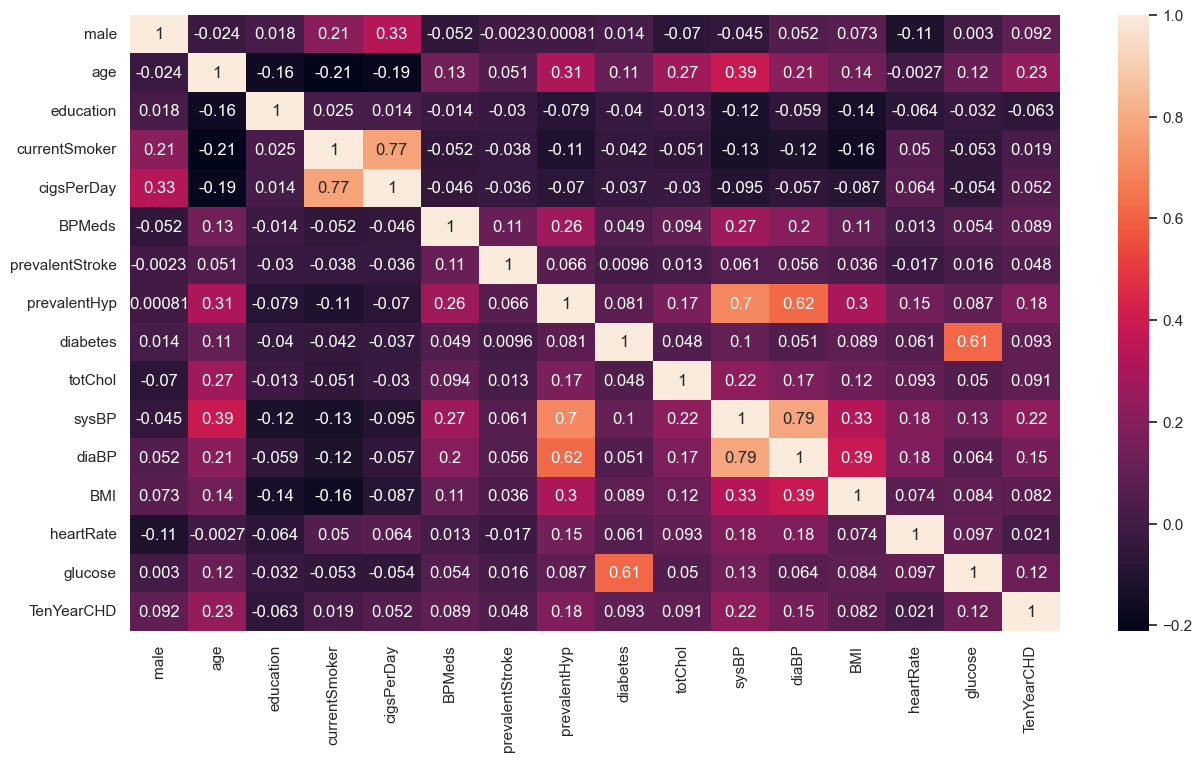

In [21]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True);

We see that there are multiple collinear variables:
- diabetes and glucose
- currentSmoker and cigsPerDay
- prevalentHyp and sysBP, diaBP
    - sysBP and diaBP

Let's address this collinearity.

Let's introduce new column with a diagnosis of Diabetes, which we will calculate based on the levels of blood glucose.

In [22]:
# Assuming that fasting blood glucose level needed to diagnose Diabetes is at least 126 mg/dL, create a column with 1 or 0 for diabetes diagnosis. (We are making approximation heer, as the gold standard for DM diagnosis is two separate tests, oral glucose tolerance test or HbA1c test).

# Function to create diabetes_calc column based on 'glucose' level
def classify_col_1_0(data, cont_col, class_col, cutoff):
    data[class_col] = 0
    data.loc[data[cont_col] >= cutoff, class_col] = 1

In [23]:
# Call function and compare columns
classify_col_1_0(data=df, 
                cont_col='glucose',
                class_col='diabetes_1_0',
                cutoff=126)

print(f'Diabetes from original data: {df["diabetes"].value_counts()[0]}\n'
        f'Diabetes calculated in new set: {df["diabetes_1_0"].value_counts()[0]}')

Diabetes from original data: 3557
Diabetes calculated in new set: 3576


Well, not much of a difference. We are off by only few patients.
Let's try to divive diabetes by stages per CDC classification:
* Normal: < 100 mg/dl
* Prediabetes: 100 to 125 mg/dl
* Diabetes: > 125 mg/dl

This will also help address all the glucose level outliers we have.

In [24]:
# Function to classify continuous column into 3 classes
def classify_col_by_3(data, cont_col, class_col, cutoff1, cutoff2):
    data[class_col] = 0
    data.loc[data[cont_col] < cutoff1, class_col] = 0
    data.loc[(data[cont_col] >= cutoff1) & (data[cont_col] < cutoff2), class_col] = 1
    data.loc[data[cont_col] >= cutoff2, class_col] = 2

In [25]:
# Call function over the glucose column
classify_col_by_3(data=df, 
                cont_col='glucose',
                class_col='diabetes_stage',
                cutoff1=100,
                cutoff2=126)

In [26]:
df[['glucose', 'diabetes_stage']].groupby('diabetes_stage').count()

,glucose
diabetes_stage,
0,3317
1,259
2,80


This reduces the number of 'normal' glucose tests and also helps to stratify the abnormal glucose values a bit better. Let's compare the correlations. 

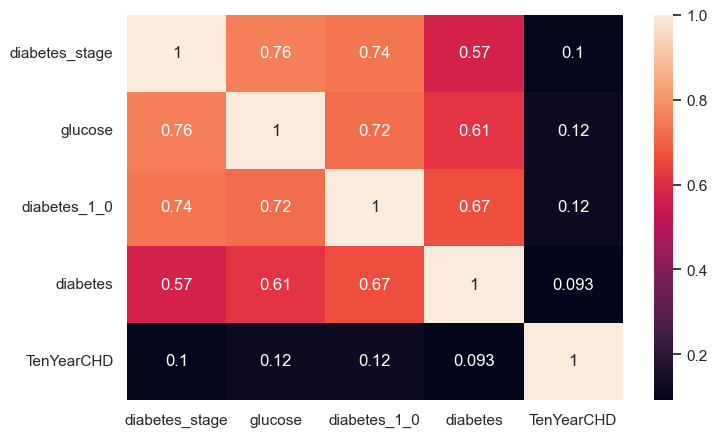

In [27]:
plt.figure(figsize=(8,5))
sns.heatmap(df[['diabetes_stage', 'glucose', 'diabetes_1_0', 'diabetes', 'TenYearCHD']].corr(), annot=True);

Let's keep the `diabetes_stage` column and drop all others.

In [28]:
# Drop the original diabetes, glucose and diabetes_1_0 columns
df.drop(columns=['diabetes', 'glucose', 'diabetes_1_0'], inplace=True) 

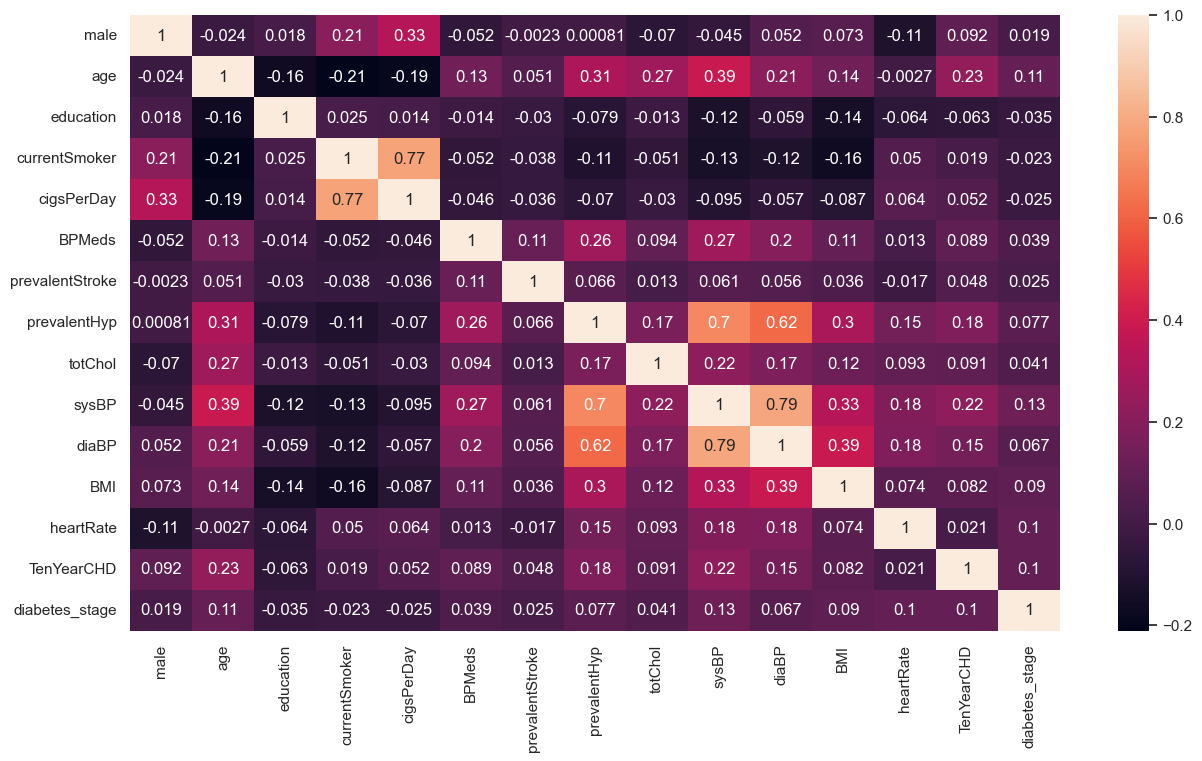

In [29]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True);

Let's move on to smoking.

In [30]:
df['currentSmoker'].value_counts()

0    1868
1    1788
Name: currentSmoker, dtype: int64

In [31]:
df['cigsPerDay'].value_counts()[:3]

0     1868
20     651
30     191
Name: cigsPerDay, dtype: int64

As expected all non-smokers have 0 cigsPerDay. So we can just drop the currentSmoker column.
Also, we can classify the cigsPerDay column.

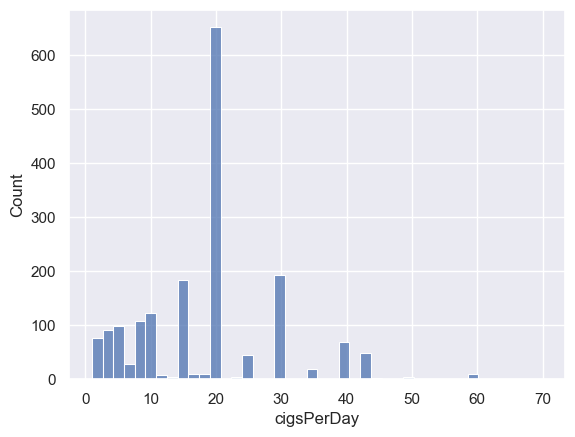

In [32]:
sns.histplot(data=df.loc[df['cigsPerDay'] > 0], x='cigsPerDay');

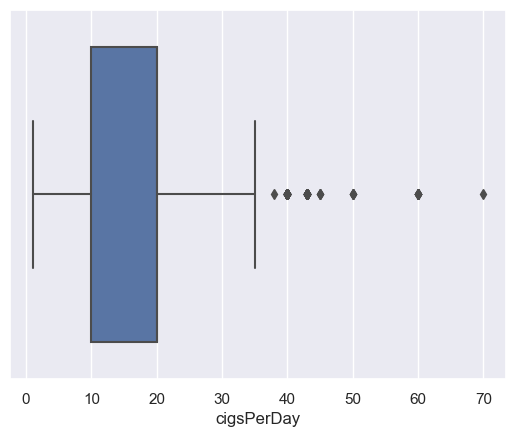

In [33]:
sns.boxplot(data=df.loc[df['cigsPerDay'] > 0], x='cigsPerDay');

Many studies tend to classify cigarettes per day as follows:
- 0 cigs/day
- 1-10 cigs/day
- 11-20 cigs/day
- more than 20 cigs/day

This somewhat reflects our data. Also, this is going to be easier to interpret, as usual cigarette pack has 20 cigarettes. Hence, the classes would mean:
- Non-smoker
- Half a pack a day
- Pack a day
- More than a pack a day

Let's implement this.

In [34]:
# Function that classifies the cigsPerDay column into 4 classes
def classify_column(data, cont_col, class_col, cutoff_list):
    data[class_col] = 0
    for i, cutoff in enumerate(cutoff_list):
        data.loc[data[cont_col] > cutoff, class_col] = i + 1

In [35]:
# Call function over the cigsPerDay column
classify_column(data=df, 
                cont_col='cigsPerDay',
                class_col='smoker_class',
                cutoff_list=[0, 10, 20])

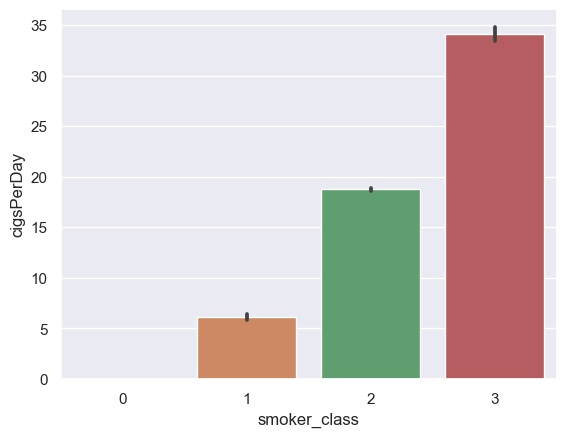

In [36]:
sns.barplot(data=df, x='smoker_class', y='cigsPerDay');

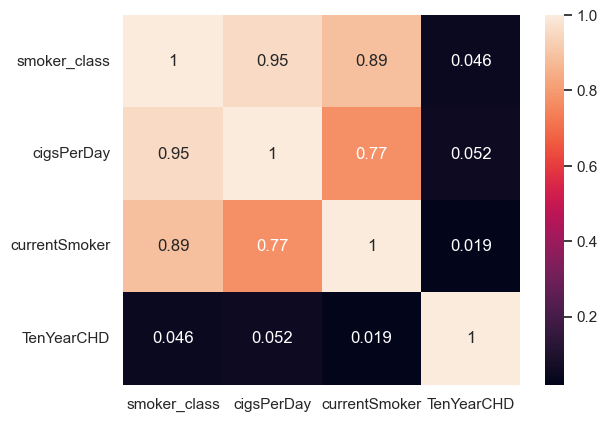

In [37]:
sns.heatmap(df[['smoker_class', 'cigsPerDay', 'currentSmoker', 'TenYearCHD']].corr(), annot=True);

It seems like this column aggregates the best of two columns. Let's drop the old ones.

In [38]:
# Drop the original cigsPerDay and currentSmoker columns
df.drop(columns=['cigsPerDay', 'currentSmoker'], inplace=True)

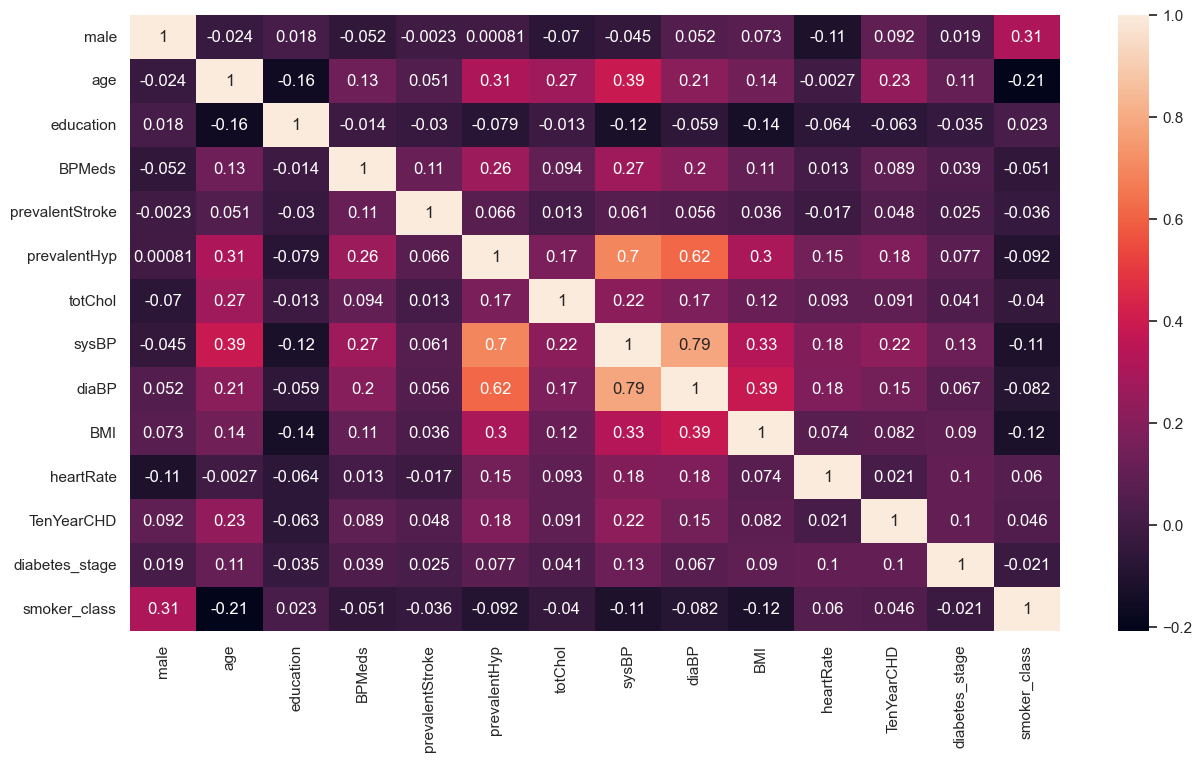

In [39]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True);

Let's move on to the blood pressure columns

For that we will need to combine systolic and diastolic blood pressures into one value. The most common way of doing that is by calculating the Mean Arterial Pressure (MAP).

$MAP = DP + (SP - DP)/3$

In [40]:
# Function to calculate the MAP (mean arterial pressure) from the systolic and diastolic blood pressure
def calculate_map(data, sys_col, dia_col, map_col):
    data[map_col] = ((data[sys_col] - data[dia_col]) / 3 + data[dia_col]).apply(lambda x: round(x, 2))

In [41]:
# Call function over the sysBP and diaBP columns
calculate_map(data=df, 
                sys_col='sysBP',
                dia_col='diaBP',
                map_col='MAP')

In [42]:
df[['sysBP', 'diaBP', 'MAP']].head()

,sysBP,diaBP,MAP
0,106.0,70.0,82.00
1,121.0,81.0,94.33
2,127.5,80.0,95.83
3,150.0,95.0,113.33
4,130.0,84.0,99.33


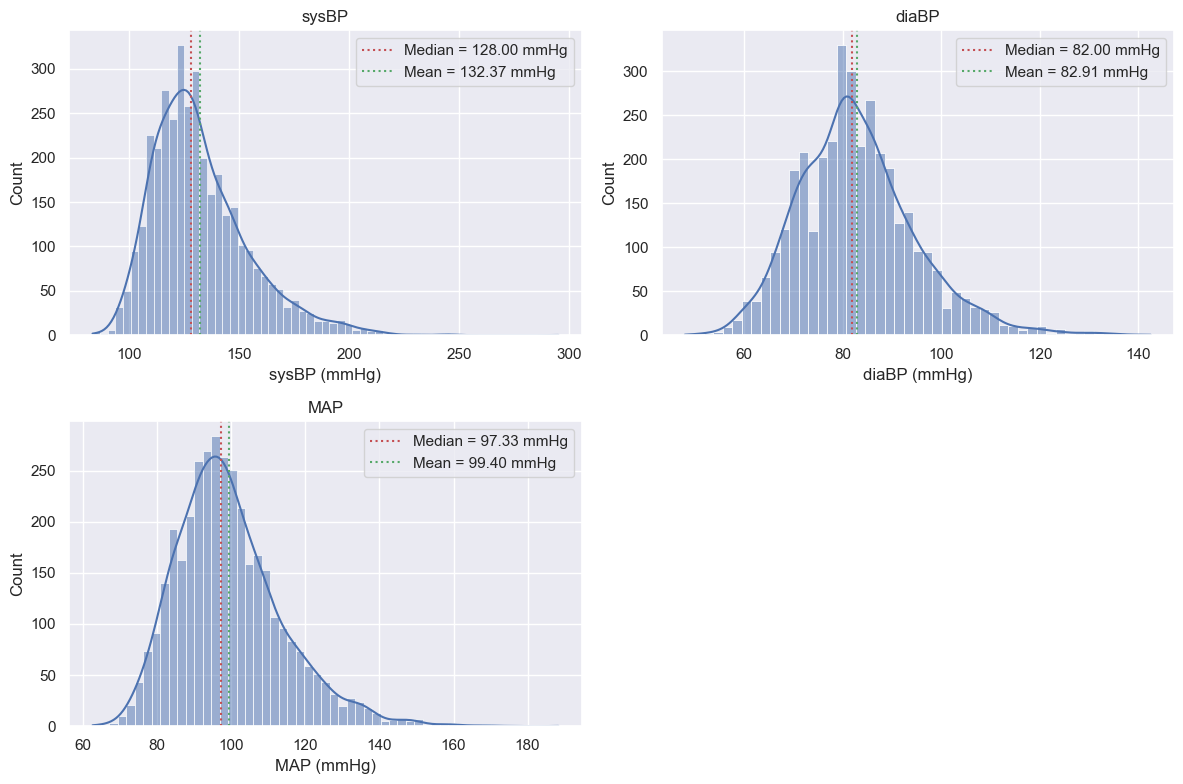

In [43]:
grid_plots.plot_grid_displots(data=df, columns=['sysBP', 'diaBP', 'MAP'], units_list=['mmHg', 'mmHg', 'mmHg'])

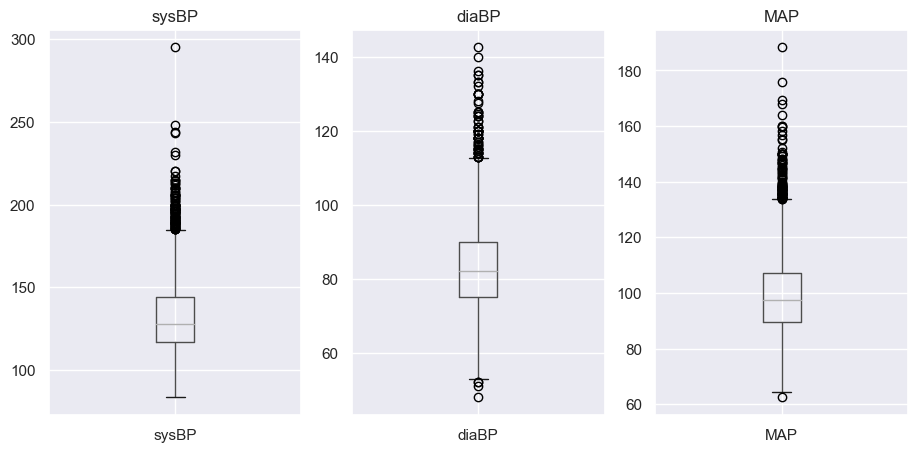

In [44]:
grid_plots.plot_box_grid(data=df, cols=['sysBP', 'diaBP', 'MAP'], figsize=(15,5))

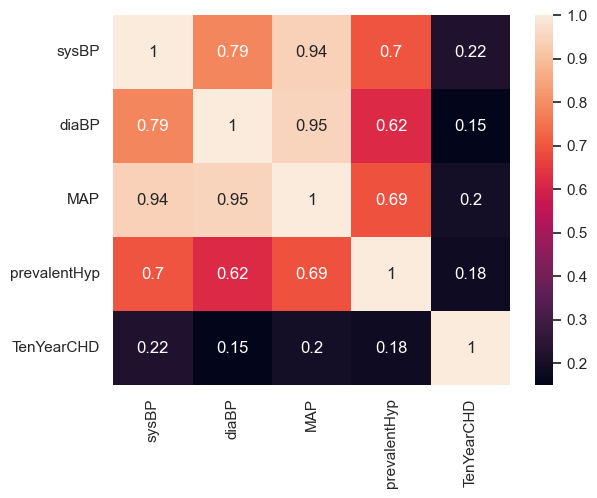

In [45]:
sns.heatmap(df[['sysBP', 'diaBP', 'MAP', 'prevalentHyp', 'TenYearCHD']].corr(), annot=True);

We can remove sysBP and diaBP columns. Also, we can classify hypertension stages:

- Optimal MAP value: <93.33
- Normal MAP value: 93.33 – 99.00
- High normal value: 99.01 – 105.67
- Grade 1 hypertension: 105.68 – 119.00
- Grade 2 hypertension:119.01 – 132.33
- Grade 3 hypertension: ≥132.34

We will stratify our classes as follows:
0. Normal MAP: < 99
1. High normal MAP: 99.01 – 105.67
2. Grade 1 hypertension: 105.68 – 119.00
3. Grade 2 hypertension:119.01 – 132.33
4. Grade 3 hypertension: ≥132.34

In [46]:
# Compare prevalentHyp and MAP columns for normal blood pressure patients
df[df['MAP'] < 105.68]['MAP'].count(), df[(df['prevalentHyp'] == 0)]['prevalentHyp'].count()

(2641, 2517)

This approximates the values we have in the `prevalentHyp` column pretty good.

In [47]:
map_htn_cutoffs = [105.67, 119.0, 132.33]

# Call classify_column function over the MAP column
classify_column(data=df, 
                cont_col='MAP',
                class_col='hypertension_stage',
                cutoff_list=map_htn_cutoffs)

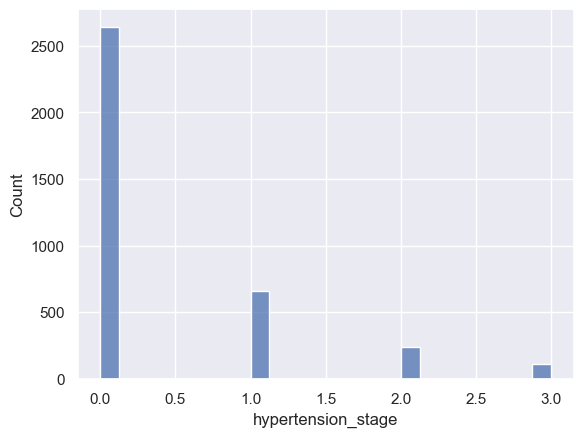

In [48]:
sns.histplot(data=df, x='hypertension_stage');

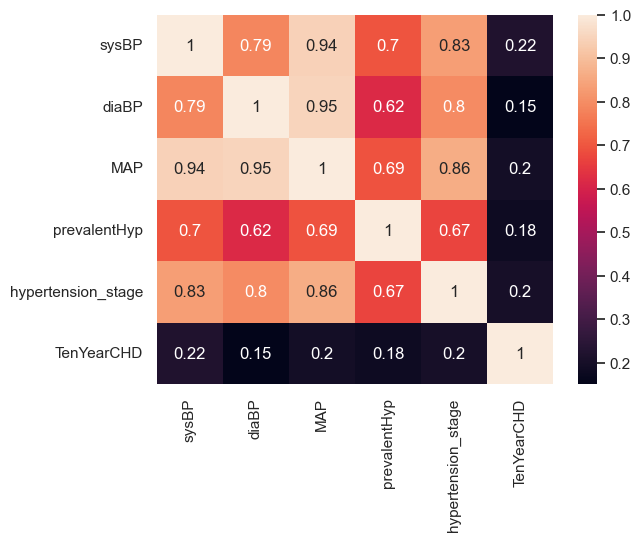

In [49]:
sns.heatmap(df[['sysBP', 'diaBP', 'MAP', 'prevalentHyp', 'hypertension_stage', 'TenYearCHD']].corr(), annot=True);

In [50]:
# Drop the original sysBP and diaBP columns and the prevalentHyp column
df.drop(columns=['sysBP', 'diaBP', 'prevalentHyp'], inplace=True)

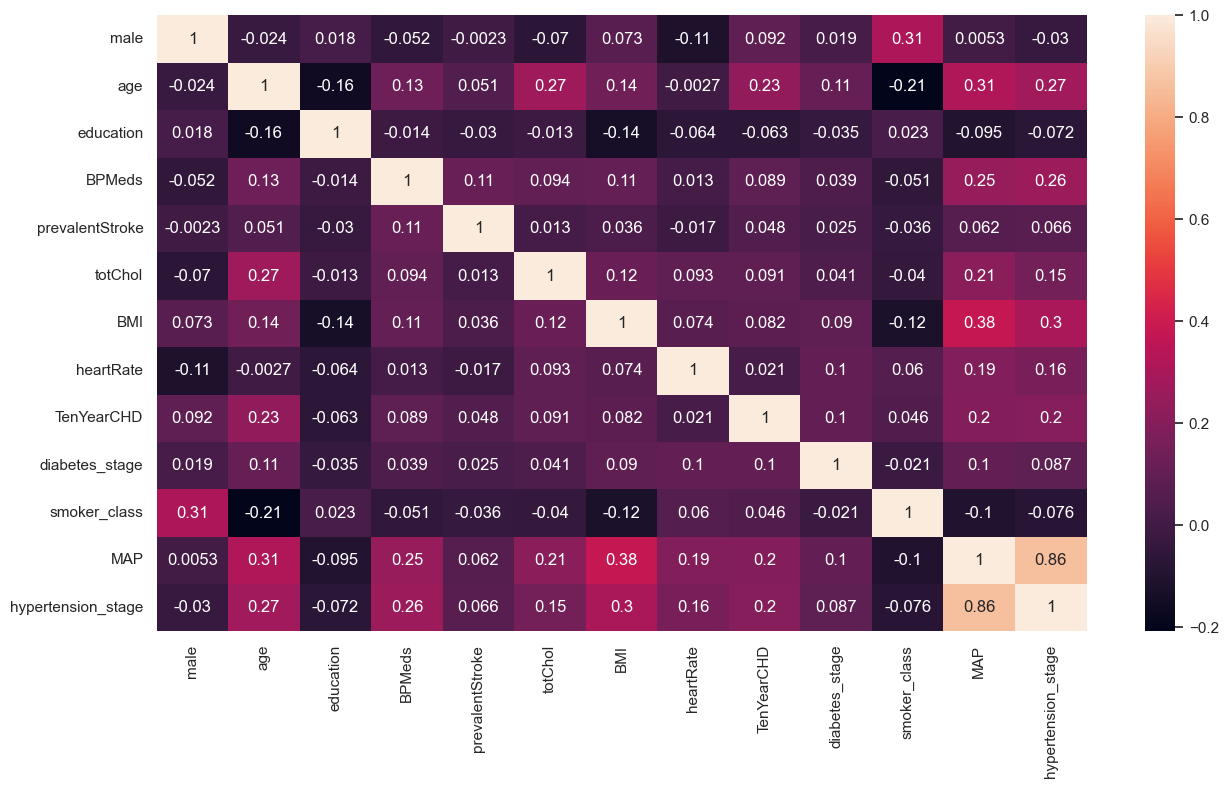

In [51]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True);

We will leave both MAP and hypertension_stage columns for now.

In [ ]:
# Export the data to a new csv file
export_path = '../data/interim/'
sb_utils.save_file(df, fname='data_eda.csv', dname=export_path)